In [ ]:
!pip install torchtext

In [ ]:
!pip install torchdata

In [15]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/root/miniconda3/lib/python3.10/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/root/miniconda3/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/root/miniconda3/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATU

In [18]:
# Define the model
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

# Load and preprocess the dataset
train_iter = AG_NEWS(split='train')


def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(vocab(tokenizer(_text)), dtype=torch.int64)
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return label_list.to(device), text_list.to(device)

train_iter = AG_NEWS(split='train')
test_iter = AG_NEWS(split='test')

train_dataloader = DataLoader(train_iter, batch_size=64, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, batch_size=64, collate_fn=collate_batch)

In [19]:
tokenizer = get_tokenizer('basic_english')

In [20]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [21]:
# Train the model
vocab_size = len(vocab)
embed_dim = 64
num_classes = len(set([label for (label, text) in train_iter]))
model = TextClassifier(vocab_size, embed_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    count = 0
    for labels, text in train_dataloader:
        optimizer.zero_grad()
        logits = model(text)
        loss = criterion(logits, labels-1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        count += 1
    train_loss /= count
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# Evaluate the model and output logits and labels for the test set
model.eval()
test_logits = []
test_labels = []
with torch.no_grad():
    for labels, text in test_dataloader:
        logits = model(text)
        test_logits.extend(logits.tolist())
        test_labels.extend((labels-1).tolist())

# print("Test Logits:")
# print(test_logits.shape)
# print("Test Labels:")
# print(test_labels.shape)

# test_logits = torch.Tensor(test_logits)
# test_labels = torch.Tensor(test_labels).long()

Epoch 1/5, Train Loss: 0.7998
Epoch 2/5, Train Loss: 0.3478
Epoch 3/5, Train Loss: 0.2739
Epoch 4/5, Train Loss: 0.2353
Epoch 5/5, Train Loss: 0.2073


In [22]:
logits = torch.Tensor(test_logits)
labels = torch.Tensor(test_labels).long()

In [8]:
from torchcp.classification.predictors import SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS, THRRANK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def evaluation(cal_x, cal_y, test_x, test_y, score_function, score_function_param=None,
                        alpha=0.01, dataset='NLP'):
    print(
        f"Experiment--Data : {dataset}, Score : {score_function.__name__}, Predictor : SplitPredictor, Alpha : {alpha}")
    
    if not torch.is_tensor(cal_x):
        cal_x = torch.from_numpy(cal_x).double()
        cal_y = torch.from_numpy(cal_y).long()
        test_x = torch.from_numpy(test_x).double()
        test_y = torch.from_numpy(test_y).long()
        
    if score_function_param is not None:
        if isinstance(score_function_param, tuple):
            predictor = SplitPredictor(score_function(*score_function_param))
        else:
            predictor = SplitPredictor(score_function(score_function_param))
    else:
        predictor = SplitPredictor(score_function())

    predictor.calculate_threshold(cal_x, cal_y, alpha)
    prediction_sets = []
    labels_list = []
    prediction_sets = predictor.predict_with_logits(test_x)
    # prediction_sets.append(prediction_sets_batch)
    labels_list = test_y
    
    metrics = predictor.evaluate_scores(prediction_sets, torch.Tensor(labels_list).long(), alpha)
    coverage = np.round(metrics['Coverage_rate'], 3)
    size = np.round(metrics['Average_size'], 3)
    sscv = np.round(metrics['SSCV'], 3)
    print(f"Coverage: {coverage}; Size: {size}; SSCV: {sscv}")

    # Create a DataFrame to store the evaluation metrics
    metrics_df = pd.DataFrame({'Data': [dataset],
                               'Alpha': [alpha],
                               'Score Function': [score_function.__name__],
                               'Coverage': [coverage],
                               'Size': [size], 
                               'SSCV': [sscv]})
    return metrics_df

In [ ]:
alphas = np.linspace(0.1, 0.3, 11) # np.linspace(0.02, 0.1, 5)
score_functions = [THRRANK, APS, RAPS, SAPS] #
score_function_params = {RAPS: (0.2, 2), SAPS: 0.2}
num_repetitions = 100
results_df = pd.DataFrame(columns=['Data', 'Alpha', 'Score Function', 'Coverage', 'Size', 'SSCV'])

name = 'agnews'
for alpha in alphas:
    index = np.arange(len(logits))

    for score_function in score_functions:
        coverage_values = []
        size_values = []
        sscv_values = []
        for run_id in range(num_repetitions):
            np.random.shuffle(index)
            n = len(logits) // 2
            cal_scores = logits[index][:n]
            val_scores = logits[index][n:]
            cal_targets = labels[index][:n]
            val_targets = labels[index][n:]

            if score_function in score_function_params:
                score_function_param = score_function_params[score_function]
            else:
                score_function_param = None

            metrics_df = evaluation(cal_scores, cal_targets, val_scores, val_targets, score_function, score_function_param, alpha=alpha, dataset=name)
            coverage_values.append(metrics_df['Coverage'].values[0])
            size_values.append(metrics_df['Size'].values[0])
            sscv_values.append(metrics_df['SSCV'].values[0])
            

        # Calculate the median-of-means for coverage and size
        median_coverage = pd.Series(coverage_values).mean()
        median_size = pd.Series(size_values).mean()
        median_sscv = pd.Series(sscv_values).mean()

        # Add the median-of-means results to the DataFrame
        results_df.loc[len(results_df)] = [name, alpha,
                                           f"Ours ({score_function})" if isinstance(score_function,
                                                                                    str) else score_function.__name__,
                                           median_coverage, median_size, median_sscv]


Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.907; Size: 0.977; SSCV: 0.007
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.898; Size: 0.967; SSCV: 0.002
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.897; Size: 0.967; SSCV: 0.003
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.892; Size: 0.962; SSCV: 0.008
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.896; Size: 0.967; SSCV: 0.004
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.899; Size: 0.968; SSCV: 0.001
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.922; Size: 0.994; SSCV: 0.022
Experiment--Data : agnews, Score : THRRANK, Predictor : SplitPredictor, Alpha : 0.1
Coverage: 0.904; Size: 0.973; SSCV

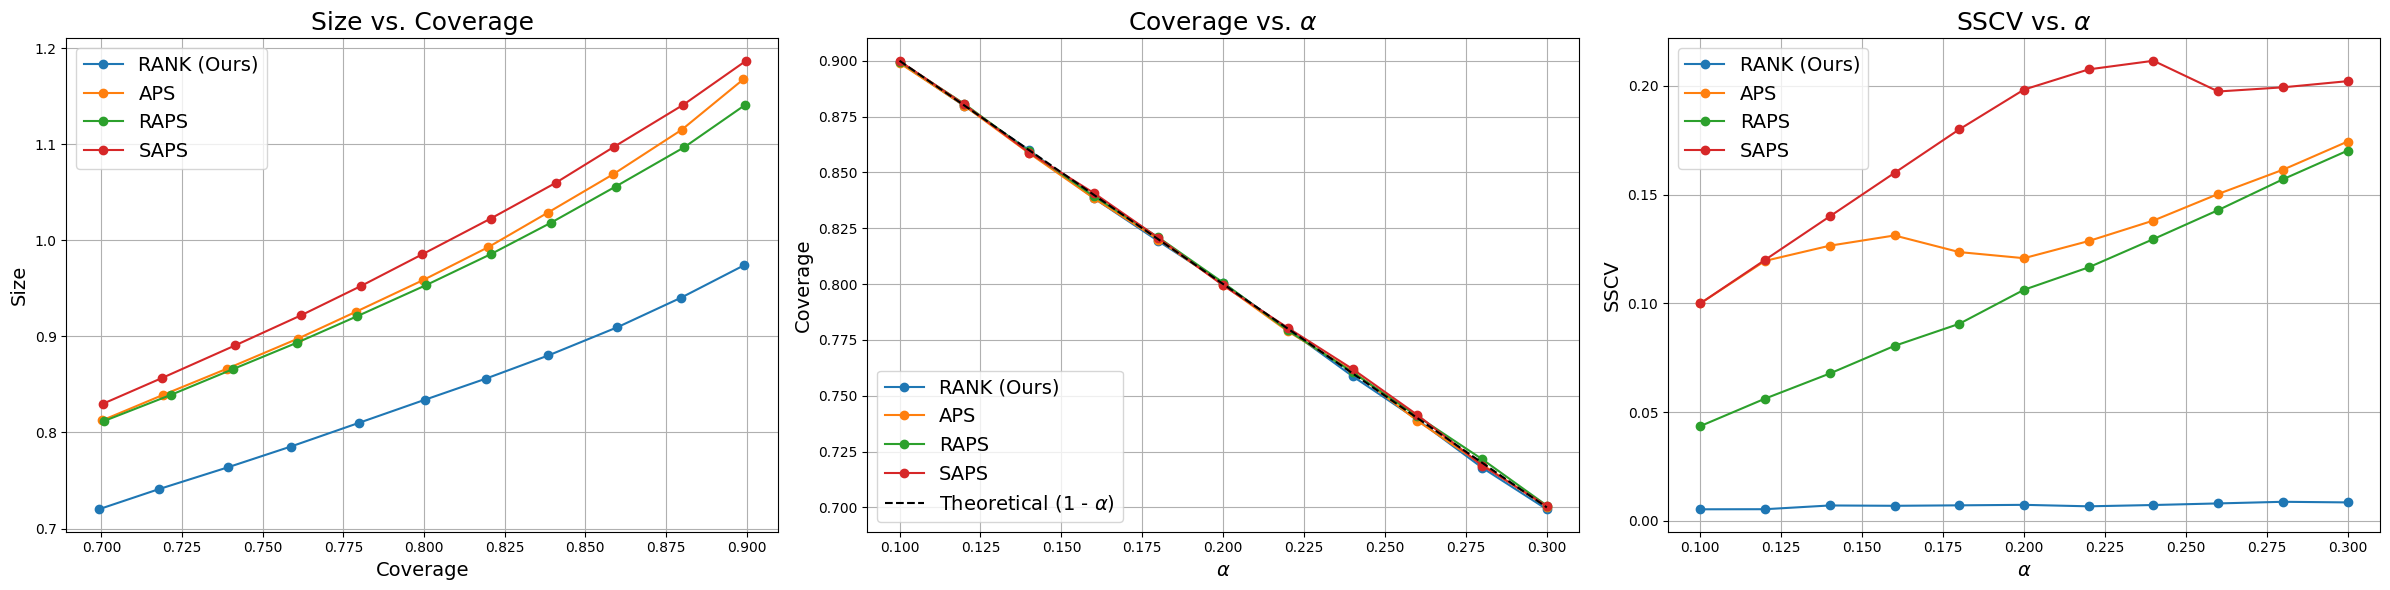

In [11]:
colors = plt.get_cmap("tab10")
names = ['THRRANK', 'APS', 'RAPS', 'SAPS']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Plot Size vs. Coverage
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax1.plot(result['Coverage'], result['Size'], color=colors(idx), linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax1.plot(result['Coverage'], result['Size'], color=colors(idx), linestyle='-', marker='o', label=names[idx])

ax1.set_xlabel('Coverage', fontsize=14)
ax1.set_ylabel('Size', fontsize=14)
ax1.set_title('Size vs. Coverage', fontsize=18)
ax1.legend(loc='upper left', fontsize=14)
ax1.grid(True)

# Plot Coverage vs. Alpha
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax2.plot(result['Alpha'], result['Coverage'], color=colors(idx), linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax2.plot(result['Alpha'], result['Coverage'], color=colors(idx), linestyle='-', marker='o', label=names[idx])

# Generate the theoretical line 1 - alpha
theoretical_coverage = [1 - alpha for alpha in alphas]
ax2.plot(alphas, theoretical_coverage, color='black', linestyle='--', label='Theoretical (1 - $\\alpha$)')

ax2.set_xlabel('$\\alpha$', fontsize=14)
ax2.set_ylabel('Coverage', fontsize=14)
ax2.set_title('Coverage vs. $\\alpha$', fontsize=18)
ax2.legend(loc='lower left', fontsize=14)
ax2.grid(True)

# Plot Alpha vs. SSCV
for idx, score_function in enumerate(score_functions):
    result = results_df[results_df['Score Function'] == names[idx]]
    if score_function == THRRANK:
        ax3.plot(result['Alpha'], result['SSCV'], color=colors(idx), linestyle='-', marker='o', label="RANK (Ours)")
    else:
        ax3.plot(result['Alpha'], result['SSCV'], color=colors(idx), linestyle='-', marker='o', label=names[idx])

ax3.set_xlabel('$\\alpha$', fontsize=14)
ax3.set_ylabel('SSCV', fontsize=14)
ax3.set_title('SSCV vs. $\\alpha$', fontsize=18)
ax3.legend(loc='upper left', fontsize=14)
ax3.grid(True)

plt.tight_layout()
plt.show()
fig.savefig('agnews.pdf')

In [ ]:
results_df.to_csv('agnews.csv')